# Semana 02

## Criação dos modelos de machine learning

Tendo feito o tratamento e análise dos dados, agora podemos construir modelos de classificação que serão úteis para a empresa determinar se o cliente deixará de assinar os serviços ou não, entre os modelos que podemos criar estão o Decision Tree e Random Forest e o gradient boosting.

### Importando bibliotecas

Para a aplicação utilizaremos `pandas`, `seaborn`, `sklearn`, `imblearn` e `sys`. Para saber mais sobre as bibliotecas sklearn e imblearn, acesse a documentação:
- [Scikit Learn](https://scikit-learn.org/stable/); e
- [Imbalanced Learn](https://imbalanced-learn.org/stable/).

In [3]:
import sys
sys.path.append('../')

import pandas as pd
import seaborn as sns
import numpy as np

# Criação dos modelos de machine learning
from utils.utils import plot_countplot, plot_matriz_confusao, compara_modelos_metricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Otimizando os modelos de machine learning
from sklearn.model_selection import GridSearchCV

# Mudando o estilo dos gráficos
sns.set_theme(style="darkgrid")

# Definindo o SEED para reprodução dos resultados
SEED = 42

## Feature Engineering

Lendo o dataset salvo na semana 1:

In [4]:
df_telecom = pd.read_json("../Dados/Telco-Customer-Churn-limpeza.json")
df_telecom.head()

,customer_id,churn,customer_gender,customer_senior_citizen,customer_partner,customer_dependents,customer_tenure,phone_service,multiple_lines,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


Agora, é preciso remover algumas colunas que não são tão importantes para a análise que desejamos realizar. O método que permite remover colunas é o `drop()` da biblioteca pandas.

Existem duas colunas que não são interessantes para a análise e que serão removidas:

* Coluna `custumerID`: Seu valor é único para cada linha e não nos traz informação relevante para uma análise, então podemos retirá-la; e
* Coluna `Charges.Total`: essa coluna contém informações dos meses de `Charges.Monthly` multiplicado por `tenure`, então é uma informação "duplicada".

In [5]:
df_telecom.columns

Index(['customer_id', 'churn', 'customer_gender', 'customer_senior_citizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [6]:
df_telecom.drop(['customer_id', 'total_charges'], axis=1, inplace=True)
df_telecom.head()

,churn,customer_gender,customer_senior_citizen,customer_partner,customer_dependents,customer_tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9


Vamos imprimir as classes de cada coluna que seja do tipo categórica para entender quais tratamentos e onde podem ser realizados.

In [7]:
for i in df_telecom.columns:
       print(f"{i}: {df_telecom[i].unique()}")

churn: ['No' 'Yes']
customer_gender: ['Female' 'Male']
customer_senior_citizen: [0 1]
customer_partner: ['Yes' 'No']
customer_dependents: ['Yes' 'No']
customer_tenure: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42
  0]
phone_service: ['Yes' 'No']
multiple_lines: ['No' 'Yes' 'No phone service']
internet_service: ['DSL' 'Fiber optic' 'No']
online_security: ['No' 'Yes' 'No internet service']
online_backup: ['Yes' 'No' 'No internet service']
device_protection: ['No' 'Yes' 'No internet service']
tech_support: ['Yes' 'No' 'No internet service']
streaming_tv: ['Yes' 'No' 'No internet service']
streaming_movies: ['No' 'Yes' 'No internet service']
contract: ['One year' 'Month-to-month' 'Two year']
paperless_billing: ['Yes' 'No']
payment_method: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (aut

In [8]:
for i in df_telecom.select_dtypes(include=['object']).columns:
       print(f"{i}: {df_telecom[i].unique()}")

churn: ['No' 'Yes']
customer_gender: ['Female' 'Male']
customer_partner: ['Yes' 'No']
customer_dependents: ['Yes' 'No']
phone_service: ['Yes' 'No']
multiple_lines: ['No' 'Yes' 'No phone service']
internet_service: ['DSL' 'Fiber optic' 'No']
online_security: ['No' 'Yes' 'No internet service']
online_backup: ['Yes' 'No' 'No internet service']
device_protection: ['No' 'Yes' 'No internet service']
tech_support: ['Yes' 'No' 'No internet service']
streaming_tv: ['Yes' 'No' 'No internet service']
streaming_movies: ['No' 'Yes' 'No internet service']
contract: ['One year' 'Month-to-month' 'Two year']
paperless_billing: ['Yes' 'No']
payment_method: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


É possível notar que algumas colunas tem a classe `No phone service` e `No internet service` que equivale a classe `No`, ou seja, não existe serviço. Para essas classes, vamos considerá-las como `No` para evitar uma informação duplicada. Como terão apenas dois resultados `Yes` e `No` (`Sim` e `Não`), substituiremos por um número binário, 1 e 0.

Além disso, as colunas 'payment_method', 'contract' e 'internet_service' possuem mais de 2 categorias e por conta disso, faremos encoding para os dados dessas colunas.

In [9]:
dicionario = {'No internet service':0,
              'No phone service': 0,
              'No': 0,
              'Yes': 1,
              'Male':0,
              'Female':1}

In [10]:

# selecionando as colunas que deseja alterar
colunas = ['churn', 'customer_gender', 'customer_senior_citizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_service', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges']

df_telecom[colunas] = df_telecom[colunas].replace(dicionario)

In [11]:
for i in df_telecom.select_dtypes(include=['object']).columns:
       print(f"{i}: {df_telecom[i].unique()}")

internet_service: ['DSL' 'Fiber optic' 'No']
contract: ['One year' 'Month-to-month' 'Two year']
payment_method: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


Existem várias formas de criar encoding, duas delas são o Label Encoding e o One-Hot Encoding.

#### Tipos de encoding

* `Label Encoding` - Renomea as classes com valores numéricos de 1 a n, sendo n o número de classes. Pode existir hierarquia entre as classes.

* `One-Hot Encoding`  - Transforma as variáveis em n colunas binárias, sendo n o número de classes. Todas as classes são analisadas de forma igual, quando tiver a ocorrência dela a coluna terá o valor 1 e quando não o valor 0, isso acontece para as demais colunas criadas.

No nosso caso, vamos optar pelo método que transforma as variáveis em colunas binárias. Para saber mais sobre esse método consulte a documentação.

- [OneHotEncoder documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

É possível também preparar essa forma de encoding com [`get_dummies` do pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), se quiser saber mais sobre esse método e o primeiro, recomendamos a leitura do artigo [Pandas Get Dummies (One-Hot Encoding) – pd.get_dummies()](https://amiradata.com/pandas-get-dummies/).

Fique a vontade para testar as duas maneiras.

In [10]:
# dados para a semana 3

df_telecom.to_csv("../Dados/Telco-Customer-Churn-deploy.csv", index=False)

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

colunas_categoricas = ['payment_method', 'contract', 'internet_service']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    colunas_categoricas),
    remainder='passthrough')

dados_ohe = one_hot_enc.fit_transform(df_telecom)
dados_ohe = pd.DataFrame(dados_ohe, columns=one_hot_enc.get_feature_names_out())
dados_ohe

,onehotencoder__payment_method_Bank transfer (automatic),onehotencoder__payment_method_Credit card (automatic),onehotencoder__payment_method_Electronic check,onehotencoder__payment_method_Mailed check,onehotencoder__contract_Month-to-month,onehotencoder__contract_One year,onehotencoder__contract_Two year,onehotencoder__internet_service_DSL,onehotencoder__internet_service_Fiber optic,onehotencoder__internet_service_No,...,remainder__phone_service,remainder__multiple_lines,remainder__online_security,remainder__online_backup,remainder__device_protection,remainder__tech_support,remainder__streaming_tv,remainder__streaming_movies,remainder__paperless_billing,remainder__monthly_charges
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,65.60
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.90
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,73.90
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,98.00
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,83.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,55.15
7039,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,85.10
7040,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50.30
7041,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,67.85


In [15]:
dados_ohe = dados_ohe.rename(columns={'remainder__churn': 'churn'})

## Balanceamento dos dados

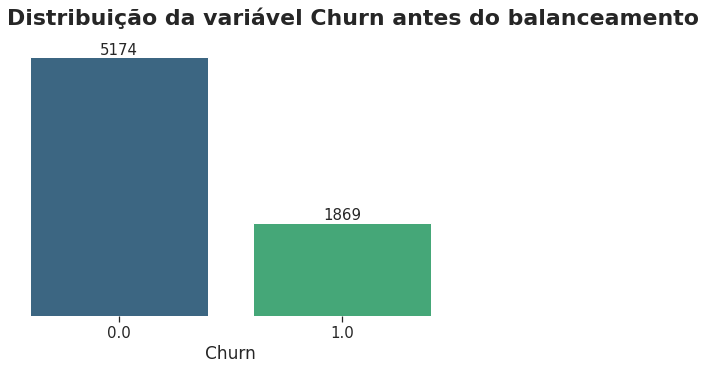

In [16]:
plot_countplot(dados=dados_ohe, 
               x='churn', 
               titulo="Distribuição da variável Churn antes do balanceamento",
               label_x='Churn'
    )

Percebemos pelo gráfico acima que o conjunto de dados possui o **alvo** (coluna `'Churn'`) [desbalanceado](https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados?utm_source=gnarus&utm_medium=timeline), caso o modelo seja criado com a variável dessa forma poderá prejudicar o aprendizados e os resultados.

Para evitar problemas no aprendizado do modelo, vamos realizar o balanceamento com o método [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) da biblioteca imblearn.

Um detalhe muito importante é que SMOTE deve ser aplicado apenas aos dados de treinamento, e não aos dados de teste. Isso porque, ao oversampling antes de dividir os dados, as mesmas observações podem acabar tanto no conjunto de treinamento quanto no conjunto de teste. Isso faria com que seu modelo tivesse uma precisão inflada quando testado, porque o modelo já viu esses exemplos durante o treinamento.

Portanto vamos primeiro dividir o conjunto de dados em treino e teste, e então aplicar SMOTE apenas ao conjunto de treinamento.

In [22]:
# Separando os dados em X, que contém os dados de entrada, e y que contém os dados de saída
X = dados_ohe.drop(['churn'], axis = 1)
y = dados_ohe['churn']

# Separando os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X , y, test_size=0.3, random_state=SEED, stratify=y)

In [28]:
from collections import Counter

smote = SMOTE(random_state=42)
X_treino_smote, y_treino_smote = smote.fit_resample(X_treino, y_treino)
print('Conjunto de dados após o balanceamento: %s' % Counter(y_treino_smote))

Conjunto de dados após o balanceamento: Counter({1.0: 3612, 0.0: 3612})


Mas vamos conferir como está o conjunto de dados para teste:

In [18]:
print('Conjunto de dados após o balanceamento: %s' % Counter(y_teste))

Conjunto de dados após o balanceamento: Counter({0: 1562, 1: 551})


Vamos utilizar esses dados nas próximas etapas, por isso vamos deixá-los salvos em um arquivo `.csv`.

## Criando os modelos

### 1. Decision Tree Classifier

O primeiro modelo a ser montado é o classificador **Decision Tree Classifier**, para montá-lo utilizamos o método [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Para entender mais sobre como esse modelo funciona, recomendamos a leitura do artigo "[Decision Trees](https://mlu-explain.github.io/decision-tree/)".

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_treino_smote, y_treino_smote)
y_pred_dt = dt.predict(X_teste)

Após treinado o modelo, precisamos saber quão bem ele foi em seu treinamento, para isso coletamos as classificações a partir de um conjunto de dados desconhecido pelo modelo, o conjunto de teste.

As respostas da avaliação de cada item do conjunto de teste realizada pelo modelo podem ser verificadas para sabermos quão bem ele foi em seu teste. A avaliação consiste na análise de várias métricas que informam o sucesso do modelo. As métricas que iremos avaliar serão [**Acurácia**](https://cursos.alura.com.br/course/machine-learning-credit-scoring/task/92910), [**Precisão, Recall e F1 Score**](https://cursos.alura.com.br/course/machine-learning-credit-scoring/task/92914) e a [**Matriz de Confusão**](https://cursos.alura.com.br/course/machine-learning-credit-scoring/task/92912)

Essas métricas nós obtemos pela função `plot_matriz_confusao()` para analisarmos o resultado final do modelo.

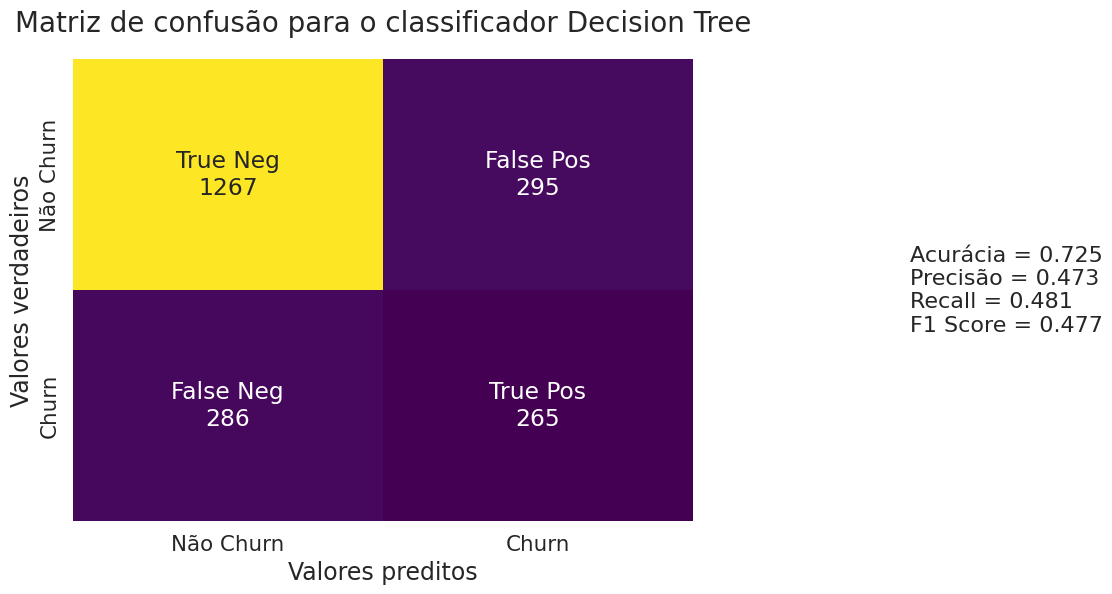

In [35]:
from utils.utils import plot_countplot, plot_matriz_confusao, compara_modelos_metricas

labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
plot_matriz_confusao(y_teste,
                      y_pred_dt,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador Decision Tree",
                      cbar=False
            )

### 2. Random Forest Classifier

O segundo modelo a ser montado é o classificador **Decision Tree**, para montá-lo utilizamos o método [Random Forest Classifier da biblioteca sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

E para saber mais sobre esse método você pode acessar o vídeo [Árvores de Decisão: aprofundando em modelos de Machine Learning](https://cursos.alura.com.br/course/arvores-decisao-aprofundando-modelos-machine-learning).

Para conferir mais detalhes sobre o modelo deixo como recomendação de leitura o artigo "[The Random Forest Algorithm](https://mlu-explain.github.io/random-forest/)"

Depois do treinado o modelo, testamos ele e plotamos a matriz de confusão e outras métricas, pela função `plot_matriz_confusao()` para analisarmos o resultado final do modelo.

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=7, random_state=SEED)
rf.fit(X_treino_smote, y_treino_smote)
y_pred_rf = rf.predict(X_teste)

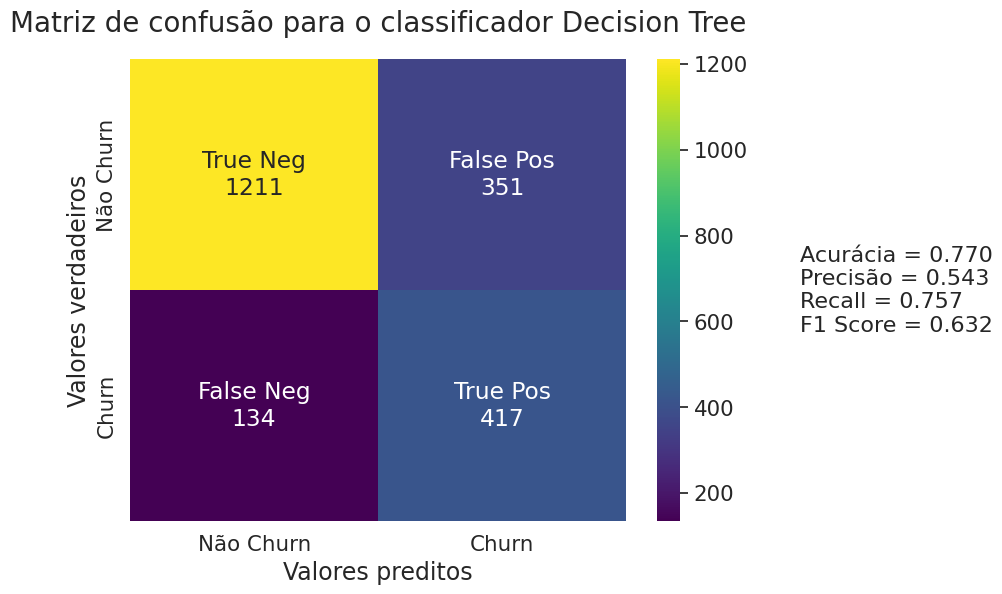

In [22]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
plot_matriz_confusao(y_teste,
                      y_pred_rf,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador Decision Tree")

### 3. Ada BoostClassifier

O segundo modelo a ser montado é o classificador **Decision Tree**, para montá-lo utilizamos o método [AdaBoostClassifier do sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

E para saber mais sobre esse método você pode acessar o vídeo [Árvores de Decisão: aprofundando em modelos de Machine Learning](https://cursos.alura.com.br/course/arvores-decisao-aprofundando-modelos-machine-learning).

Depois do treinado o modelo, testamos ele e plotamos a matriz de confusão e outras métricas, pela função `plot_matriz_confusao()` para analisarmos o resultado final do modelo.

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=SEED)
ada.fit(X_treino_smote, y_treino_smote)
y_pred_ada = ada.predict(X_teste)

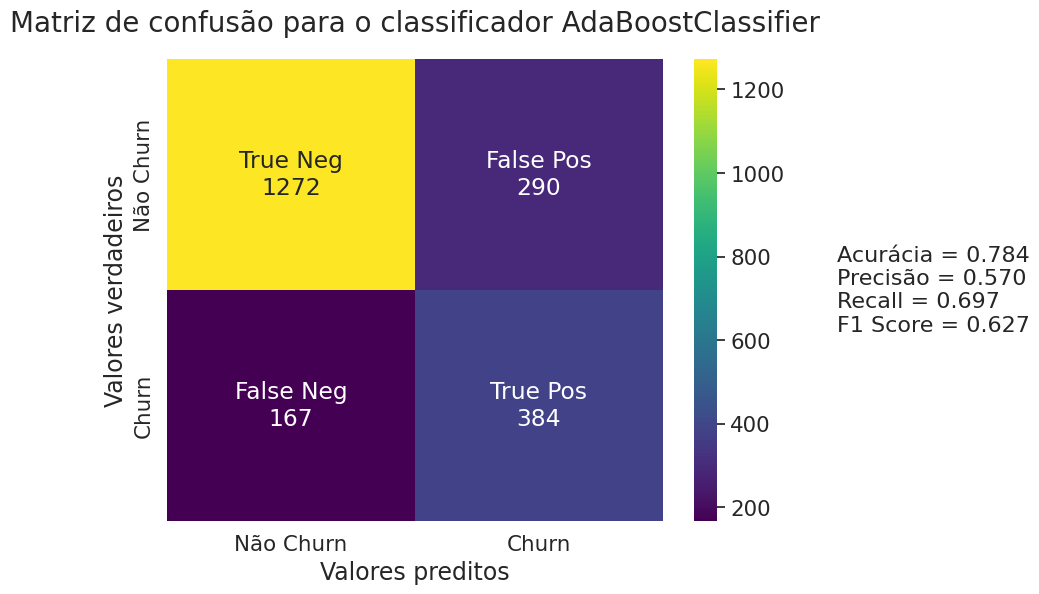

In [29]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
plot_matriz_confusao(y_teste,
                      y_pred_ada,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador AdaBoostClassifier")

## Comparando os modelos

Após o treino e teste dos modelos **Decision Tree Classifier**, **Random Forest Classifier** e **Ada BoostClassifier**, podemos fazer as comparações entre os resultado obtidos para descobrir o melhor modelo.

Para isso, coletamos as métricas de classificação dos três dos modelos agrupamos em uma tabela de comparação.

In [25]:
modelos = ['decision tree', 'random forest classifier', 'ada boost classifier']
y_pred_treinos = [dt.predict(X_treino_smote), rf.predict(X_treino_smote), ada.predict(X_treino_smote)]
y_pred_testes = [y_pred_dt, y_pred_rf, y_pred_ada]  

In [30]:
tabela_modelos = compara_modelos_metricas('F1-Score', modelos, y_treino_smote, y_pred_treinos, y_teste, y_pred_testes)
tabela_modelos

,Modelo,Acurácia Treino,Acurácia Teste,Precisão,Recall,F1-Score
0,random forest classifier,0.840255,0.770469,0.542969,0.756806,0.632297
1,ada boost classifier,0.833749,0.783720,0.569733,0.696915,0.626939
2,decision tree,0.998477,0.716517,0.461290,0.519056,0.488471


## Otimização de hiperparâmetros

|    | Modelo                   |   Acurácia Treino |   Acurácia Teste |   Precisão |   Recall |   F1-Score |
|---:|:-------------------------|------------------:|-----------------:|-----------:|---------:|-----------:|
|  0 | random forest classifier |          0.840255 |         0.770469 |   0.542969 | 0.756806 |   0.632297 |
|  1 | ada boost classifier     |          0.833749 |         0.78372  |   0.569733 | 0.696915 |   0.626939 |
|  2 | decision tree            |          0.998477 |         0.716517 |   0.46129  | 0.519056 |   0.488471 |


Ao desenvolver um modelo de machine learning para prever o churn de uma empresa, a métrica a ser considerada depende do contexto do problema. Vamos analisar cada uma das métricas que você mencionou:

* Acurácia: Mede a proporção de previsões corretas feitas pelo modelo. No entanto, a acurácia pode ser uma métrica enganosa se a distribuição das classes for desbalanceada. Se a maioria dos clientes não deu churn, um modelo que prevê sempre que o cliente não dará churn terá uma alta acurácia, mas não será útil.

* Precision (Precisão): Mede a proporção de previsões de churn que são realmente churn. Um valor alto de precisão indica que, quando o modelo prevê churn, é provável que seja um churn verdadeiro.

* Recall (Sensibilidade): Mede a proporção de churns reais que o modelo é capaz de capturar através de suas previsões. Um valor alto de recall indica que o modelo é bom em detectar churns.

* F1-Score: É a média harmônica entre precisão e recall. É uma métrica que busca balancear precisão e recall, sendo útil quando ambas são importantes para o problema.

No contexto de previsão de churn, geralmente queremos identificar o máximo de clientes que darão churn (alto recall), mas também queremos estar certos nas nossas previsões para não gastar recursos desnecessários tentando reter clientes que não dariam churn (alta precisão). Portanto, o F1-Score pode ser uma boa métrica a ser considerada, pois balanceia estas duas métricas.

Para entender melhor como funciona as métricas mencionadas, deixo como recomendação o alura+ [Métricas de avaliação para classificação](https://cursos.alura.com.br/extra/alura-mais/metricas-de-avaliacao-para-classificacao-c1440).

Nesse contexto o modelo escolhido é o **random forest classifier** pois é o que possui um maior f1-score.

Tendo escolhido o melhor modelo, utilizaremos o [GridSearchCV](https://cursos.alura.com.br/course/machine-learning-otimizacao-de-modelos-atraves-de-hiperparametros/task/48715) para otimizá-lo.

In [33]:
n_estimators = np.arange(100, 200, step=20)	
criterion = ["gini", "entropy"]  
max_depth = list(np.arange(2, 10, step=2))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [2, 4]
bootstrap = [True, False]

parameters = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

É preciso definir os hiperparâmetros a serem otimizados pelo GridSearchCV, os quais:

* **`n_estimators`**: número de árvores de decisão;
* **`criterion`**: critério de decisão;
* **`max_features`**: número máximo de variáveis a serem utilizadas ao procurar melhor divisão;
* **`max_depth`**: profundidade máxima da árvore de decisão;
* **`min_samples_split`**: número mínimo de amostras necessárias para que uma divisão seja feita;
* **`min_samples_leaf`**: número mínimo de amostras necessárias para que uma folha seja formada;
* **`bootstrap`**: indica se foi realizada uma reamostragem dos dados na criação dos modelos de árvore de decisão.

In [35]:
clf = GridSearchCV(RandomForestClassifier(random_state=SEED), parameters, cv=3, n_jobs=-1, scoring="f1")
clf.fit(X_treino_smote, y_treino_smote)  # ajuste com os dados de treino balanceados

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [2, 4],
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([100, 120, 140, 160, 180])},
             scoring='f1')

Após o ajuste, conseguimos analisar os resultados obtidos:

In [36]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
288,0.932817,0.042773,0.062878,0.004701,True,entropy,8,2,4,160,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.693519,0.864885,0.866339,0.808248,0.081128,1
283,1.014482,0.099439,0.059062,0.003245,True,entropy,8,2,2,160,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.693519,0.864885,0.866339,0.808248,0.081128,1
607,0.819731,0.042631,0.054705,0.002242,False,entropy,8,2,4,140,"{'bootstrap': False, 'criterion': 'entropy', '...",0.691347,0.865751,0.867397,0.808165,0.082606,3
602,0.845262,0.030233,0.053859,0.006378,False,entropy,8,2,2,140,"{'bootstrap': False, 'criterion': 'entropy', '...",0.691347,0.865751,0.867397,0.808165,0.082606,3
130,0.493007,0.017880,0.036350,0.001186,True,gini,8,2,6,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.692913,0.867939,0.863533,0.808128,0.081489,5


Para obtermos os melhores resultados do otimizador utilizamos o comando **`best_params_`**:

In [38]:
clf.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 160}

Com isso, conseguimos criar um estimador de Random Forest com os melhores hiperparâmetros:

In [39]:
best_clf = clf.best_estimator_

In [41]:
y_pred = best_clf.predict(X_teste)

Podemos analisar assim, se o modelo realmente obteve resultados melhores na métrica de *f1-score* utilizanod a função `plot_matriz_confusao`:

In [ ]:
# fazer a matriz a matriz de confusão para os dados de treino para conferir se está generalizando bem

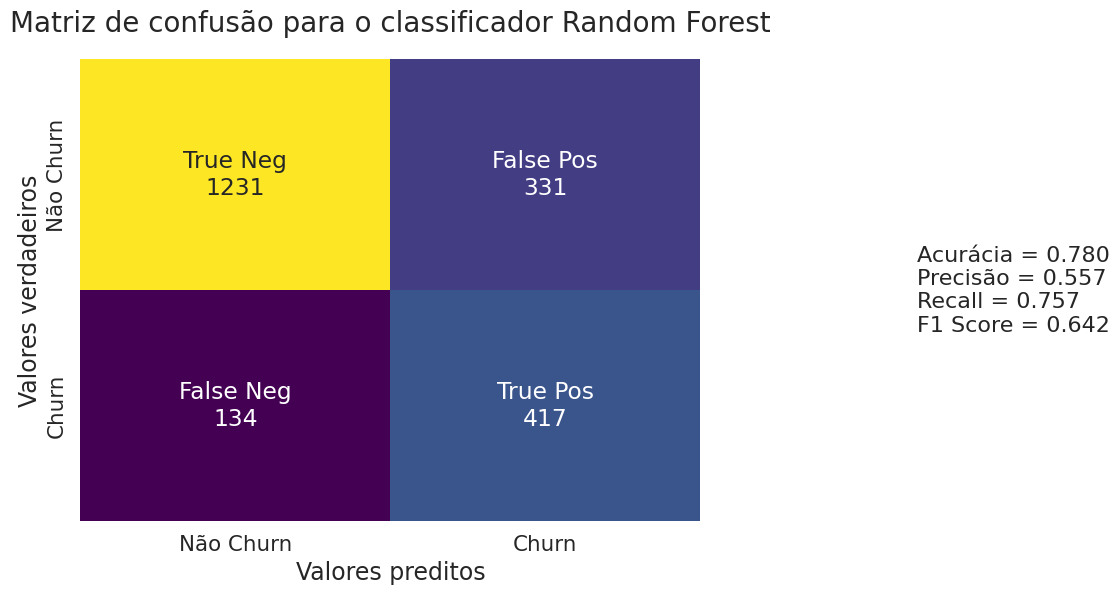

In [42]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Churn", "Churn"]
plot_matriz_confusao(y_teste,
                      y_pred,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador Random Forest",
                      cbar=False
                    )

Com isso conseguimos criar o modelo com os melhores hiperparâmetros e obter um resultado melhor na métrica de *f1-score*.

## Salvando o modelo otimizado

In [59]:
from sklearn.metrics import f1_score
import pickle

# Salvando o nome do modelo dinamicamente
f1 = f1_score(y_teste, y_pred)
nome_modelo = type(best_clf).__name__
path = "/home/bruno/challenge-agosto/modelos/"

# Converte o f1-score em string
f1_str = str(round(f1, 4))

# Salvando o modelo
with open(path + nome_modelo + '_f1_' + f1_str + '.pkl', 'wb') as file:
    pickle.dump(best_clf, file)